In [1]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator

import collections

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import mse, binary_crossentropy, categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, LeakyReLU, dot
from tensorflow.keras.layers import Reshape, Dropout, Flatten, Activation, Conv2D, UpSampling2D, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.layers import Dense, Conv3D, MaxPooling3D, Flatten, Input, Activation, add, Add, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

In [3]:
def evaluate_model(history):
    

    # Setting Parameters
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    

    # 2) Loss Plt
    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

In [4]:
train_vx = np.load('/kaggle/input/thermonet-features/Q3214.npy')
train_vx = np.moveaxis(train_vx, 1, -1)
train_vx.shape

(3214, 16, 16, 16, 14)

In [5]:
test_vx = np.load('/kaggle/input/thermonet-features/nesp_features.npy')
test_vx = np.moveaxis(test_vx, 1, -1)
test_vx.shape

(2335, 16, 16, 16, 14)

In [6]:
df_train = pd.read_csv('/kaggle/input/enzyme-dataset-cnn/train_meta.csv')
pdb_ids = df_train.pdb_id
y = df_train.ddg

df_train['label'] = 0


df_train.loc[y>2,'label'] = 4
df_train.loc[(y<=2)&(y>1), 'label'] = 3
df_train.loc[(y<=1)&(y>0), 'label'] = 2
df_train.loc[(y<=0)&(y>-0.5), 'label'] = 1



df_train

,Unnamed: 0,pdb_id,position,wild_type,mutant,ddg,label
0,0,1otrB,34,E,A,-0.07,1
1,1,1a5eA,121,L,R,-0.66,0
2,2,1rtbA,4,A,S,0.47,2
3,3,4lyzA,102,G,R,-0.38,1
4,4,1thqA,157,M,A,0.77,2
...,...,...,...,...,...,...,...
3209,3209,2lzmA,42,A,K,3.70,4
3210,3210,1yeaA,76,P,G,1.20,3
3211,3211,1stnA,104,V,T,2.50,4
3212,3212,2lzmA,71,V,A,1.50,3


In [7]:
y = df_train.ddg
y_label = df_train.label
y_std = (y-y.mean())/y.std(ddof=1)

(array([408.,   0., 346.,   0.,   0., 973.,   0., 641.,   0., 846.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

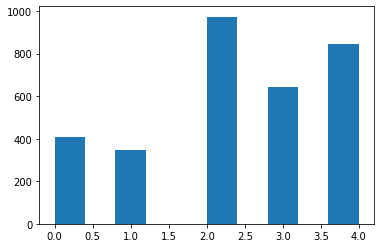

In [8]:
plt.hist(y_label)

In [15]:
hid_dim = 800

reg1 = 1e-6
reg2 = 1e-6

initial = tf.keras.initializers.HeNormal()


#model_create
input1 = Input(shape=(16, 16, 16, 14))

x = Conv3D(filters=32, kernel_size=(3, 3, 3), kernel_initializer='he_normal')(input1)
x = Activation('relu')(x)

x = Conv3D(filters=32, kernel_size=(3, 3, 3), kernel_initializer='he_normal')(x)
x = Activation('relu')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)


x = Conv3D(filters=64, kernel_size=(2, 2, 2), kernel_initializer='he_normal')(x)
x = Activation('relu')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)

x = Flatten()(x)

x =  tf.keras.layers.Reshape((1,x.shape[1]))(x)

x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hid_dim, activation='relu',
                                                  kernel_initializer=initial,
                                                  return_sequences=False))(x)

x = Dense(hid_dim,kernel_initializer=initial,kernel_regularizer=tf.keras.regularizers.l1(reg1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

x = Dense(hid_dim/2,kernel_initializer=initial,kernel_regularizer=tf.keras.regularizers.l1(reg1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)


x = Dense(hid_dim/4,kernel_initializer=initial,kernel_regularizer=tf.keras.regularizers.l1(reg1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

#output
outputs = Dense(1,kernel_initializer=initial,kernel_regularizer=tf.keras.regularizers.l2(reg2))(x)

Epoch 1/100
121/121 [==============================] - 6s 26ms/step - loss: 1.5512 - val_loss: 1.0001
Epoch 2/100
121/121 [==============================] - 2s 20ms/step - loss: 1.1985 - val_loss: 0.9162
Epoch 3/100
121/121 [==============================] - 2s 19ms/step - loss: 1.1245 - val_loss: 0.9755
Epoch 4/100
121/121 [==============================] - 3s 22ms/step - loss: 1.0996 - val_loss: 0.9002
Epoch 5/100
121/121 [==============================] - 3s 25ms/step - loss: 1.0523 - val_loss: 1.3547
Epoch 6/100
121/121 [==============================] - 2s 20ms/step - loss: 1.0300 - val_loss: 1.3497
Epoch 7/100
121/121 [==============================] - 2s 19ms/step - loss: 1.0020 - val_loss: 1.7679
Epoch 8/100
121/121 [==============================] - 3s 22ms/step - loss: 0.9689 - val_loss: 0.8024
Epoch 9/100
121/121 [==============================] - 2s 19ms/step - loss: 0.9580 - val_loss: 1.5018
Epoch 10/100
121/121 [==============================] - 2s 19ms/step - loss: 0.928

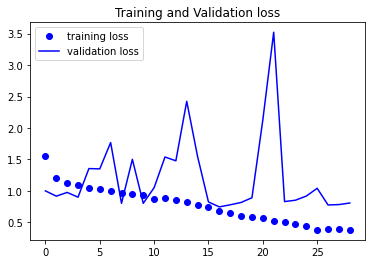

Epoch 1/100
121/121 [==============================] - 6s 26ms/step - loss: 0.8400 - val_loss: 205.4906
Epoch 2/100
121/121 [==============================] - 2s 19ms/step - loss: 0.8303 - val_loss: 0.9539
Epoch 3/100
121/121 [==============================] - 2s 21ms/step - loss: 0.7761 - val_loss: 1.2479
Epoch 4/100
121/121 [==============================] - 2s 19ms/step - loss: 0.7222 - val_loss: 6.5658
Epoch 5/100
121/121 [==============================] - 2s 19ms/step - loss: 0.7197 - val_loss: 5.3113
Epoch 6/100
121/121 [==============================] - 2s 20ms/step - loss: 0.6930 - val_loss: 0.8985
Epoch 7/100
121/121 [==============================] - 3s 22ms/step - loss: 0.6842 - val_loss: 1.3043
Epoch 8/100
121/121 [==============================] - 3s 24ms/step - loss: 0.6276 - val_loss: 1.0742
Epoch 9/100
121/121 [==============================] - 2s 19ms/step - loss: 0.6155 - val_loss: 8.9402
Epoch 10/100
121/121 [==============================] - 2s 19ms/step - loss: 0.5

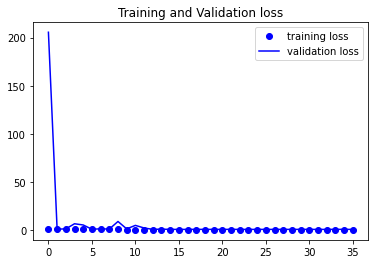

Epoch 1/100
121/121 [==============================] - 6s 29ms/step - loss: 0.5411 - val_loss: 6.3622
Epoch 2/100
121/121 [==============================] - 2s 20ms/step - loss: 0.5057 - val_loss: 0.5084
Epoch 3/100
121/121 [==============================] - 2s 19ms/step - loss: 0.4575 - val_loss: 4.9075
Epoch 4/100
121/121 [==============================] - 2s 19ms/step - loss: 0.4299 - val_loss: 0.5287
Epoch 5/100
121/121 [==============================] - 3s 22ms/step - loss: 0.4362 - val_loss: 0.4946
Epoch 6/100
121/121 [==============================] - 2s 19ms/step - loss: 0.4093 - val_loss: 0.4952
Epoch 7/100
121/121 [==============================] - 2s 19ms/step - loss: 0.3550 - val_loss: 0.8540
Epoch 8/100
121/121 [==============================] - 2s 20ms/step - loss: 0.3668 - val_loss: 0.8295
Epoch 9/100
121/121 [==============================] - 2s 19ms/step - loss: 0.3323 - val_loss: 0.4868
Epoch 10/100
121/121 [==============================] - 3s 22ms/step - loss: 0.353

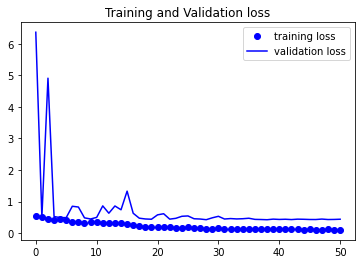

Epoch 1/100
121/121 [==============================] - 6s 26ms/step - loss: 0.3409 - val_loss: 4.1615
Epoch 2/100
121/121 [==============================] - 2s 19ms/step - loss: 0.3254 - val_loss: 0.3055
Epoch 3/100
121/121 [==============================] - 2s 19ms/step - loss: 0.3056 - val_loss: 0.6630
Epoch 4/100
121/121 [==============================] - 3s 21ms/step - loss: 0.3134 - val_loss: 0.3661
Epoch 5/100
121/121 [==============================] - 2s 19ms/step - loss: 0.3002 - val_loss: 0.5038
Epoch 6/100
121/121 [==============================] - 2s 20ms/step - loss: 0.2609 - val_loss: 0.5504
Epoch 7/100
121/121 [==============================] - 2s 20ms/step - loss: 0.2577 - val_loss: 0.7402
Epoch 8/100
121/121 [==============================] - 3s 27ms/step - loss: 0.2510 - val_loss: 0.3898
Epoch 9/100
121/121 [==============================] - 2s 20ms/step - loss: 0.2031 - val_loss: 0.2652
Epoch 10/100
121/121 [==============================] - 2s 19ms/step - loss: 0.178

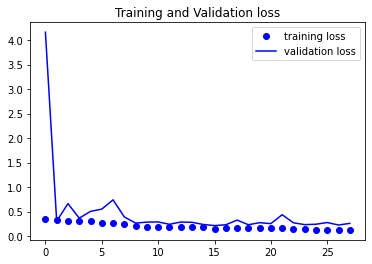

(2335, 1)


In [16]:
predict_sum = np.zeros((len(test_vx), 1), dtype=np.float32)

split_num = 4
skf = StratifiedKFold(n_splits=split_num, random_state=42, shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(skf.split(train_vx,y_label)):
    
    vx_tr = train_vx[idx_tr]
    y_tr = y_std[idx_tr]
    
    
    vx_val = train_vx[idx_va]
    y_val = y_std[idx_va]
    

    model = Model(input1, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                           patience=6, verbose=0)
    es = EarlyStopping(monitor="val_loss",
                       patience=12, 
                       verbose=0,
                       mode="min", 
                       restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    history1 = model.fit(vx_tr, y_tr, batch_size=20, epochs=100, verbose=1, validation_data=(vx_val,y_val),callbacks=callbacks)

    evaluate_model(history1)
    
    del vx_tr, y_tr, vx_val, y_val
    gc.collect()
    
    predict_sum += model.predict(test_vx)
    
    del model, history1
    gc.collect()
    
predict_sum /= split_num
print(predict_sum.shape)
    

In [17]:
df_test = pd.read_csv('/kaggle/input/enzyme-dataset-cnn/df_test.csv')
df_test

,Unnamed: 0,seq_id,protein_sequence,pH,data_source,op,idx,wild,mutant,mut,name
0,0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,E,L17E,wildtypeA
1,1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,K,L17K,wildtypeA
2,2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,delete,17,L,-,L17-,wildtypeA
3,3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,C,K18C,wildtypeA
4,4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,F,K18F,wildtypeA
...,...,...,...,...,...,...,...,...,...,...,...
2408,2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,I,A16I,wildtypeA
2409,2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,L,A16L,wildtypeA
2410,2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,N,A16N,wildtypeA
2411,2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,P,A16P,wildtypeA


In [18]:
df_test.loc[df_test.op == 'replace', 'ddg'] = -predict_sum
df_test.loc[df_test['op'] == "delete", 'ddg'] = df_test[df_test["op"]=="replace"]["ddg"].quantile(q=0.25)
df_test.loc[df_test['op'] == "same", 'ddg'] = 0.

In [20]:
df_test.rename(columns={'ddg': 'tm'})[['seq_id', 'tm']].to_csv('subm_cnn2.csv', index=False)